In [4]:
import os

import numpy as np
import tensorflow as tf
from argparse import ArgumentParser

from data_manager.dataset_processing import concatenate_chunks, quantile_clipping, exp_root_norm
from memory_manager.gpu_manager import set_gpus_used
from models.edsr import edsr
from utils.plotting.tm_lr_hr_sr import plot_lr_hr_sr
import matplotlib.pyplot as plt
from config import config_centralized

In [5]:
# GPU Settings
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    set_gpus_used([0, 1, 2, 3])

4 Physical GPUs, 4 Logical GPU


In [6]:
 # Initialization and Configuration
TRAFFIC_MATRICES_BASE_PATH = "/home/ubuntu/edtmsr/facebook_data/"

# Input parameters
SCALE_FACTOR = 2
WINDOW_SIZE = 180
AGGREGATION_FREQ = "10S"

NUM_HR_PIXELS = config_centralized.TM_ORIGINAL_SIZE - config_centralized.TM_ORIGINAL_SIZE % SCALE_FACTOR

In [7]:
import numpy as np

def minmax_scale(images):
    # Assuming images is a 4D array with shape (N, 32, 32)
    min_val = np.min(images)
    max_val = np.max(images)
    
    scaled_images = (images - min_val) / (max_val - min_val)
    
    return scaled_images

In [8]:
from sklearn.model_selection import train_test_split
from traffic_matrix_helper.helper import generate_training_data, create_tensor
from sklearn.preprocessing import MinMaxScaler
 
 # Load and preprocess data
hr_original_size_path = TRAFFIC_MATRICES_BASE_PATH + f"/traffic_matrices_{AGGREGATION_FREQ}_pod"
hr_original_size_path_shuffled = TRAFFIC_MATRICES_BASE_PATH + f"/traffic_matrices_{AGGREGATION_FREQ}_pod_shuffled"
hr_original = concatenate_chunks(hr_original_size_path_shuffled)
hr_original = quantile_clipping(hr_original, config_centralized.QUANTILE_PERCENTAGE)
hr_original = exp_root_norm(hr_original, config_centralized.NORMALIZATION_EXP)

# Normalize hr_original between 0 and 1
hr_original = minmax_scale(hr_original)

# Split the data into train, test, and validation sets
train_data, test_data = train_test_split(hr_original, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

lr_images, hr_images = generate_training_data(hr_original, crop_size=32, scale_factor=2, window_size=28)
lr_images_val, hr_images_val = generate_training_data(val_data, crop_size=32, scale_factor=2, window_size=28)
lr_images_test, hr_images_test = generate_training_data(test_data, crop_size=32, scale_factor=2, window_size=28)


[DEBUG] chunk file:  2016-10-01-19-00-00.npy
[DEBUG] chunk file:  2016-10-02-02-00-00.npy
[DEBUG] chunk file:  2016-10-01-10-00-00.npy
[DEBUG] chunk file:  2016-10-02-03-00-00.npy
[DEBUG] chunk file:  2016-10-02-01-00-00.npy
[DEBUG] chunk file:  2016-10-01-21-00-00.npy
[DEBUG] chunk file:  2016-10-01-22-00-00.npy
[DEBUG] chunk file:  2016-10-01-23-00-00.npy
[DEBUG] chunk file:  2016-10-01-12-00-00.npy
[DEBUG] chunk file:  2016-10-01-11-00-00.npy
[DEBUG] chunk file:  2016-10-01-16-00-00.npy
[DEBUG] chunk file:  2016-10-01-15-00-00.npy
[DEBUG] chunk file:  2016-10-01-09-00-00.npy
[DEBUG] chunk file:  2016-10-01-13-00-00.npy
[DEBUG] chunk file:  2016-10-02-00-00-00.npy
[DEBUG] chunk file:  2016-10-01-20-00-00.npy
[DEBUG] chunk file:  2016-10-01-14-00-00.npy


In [9]:
print(lr_images.shape, hr_images.shape)
print(lr_images_val.shape, hr_images_val.shape)
print(lr_images_test.shape, hr_images_test.shape)


(126000, 28, 28, 1) (126000, 28, 28, 1)
(20175, 28, 28, 1) (20175, 28, 28, 1)
(25200, 28, 28, 1) (25200, 28, 28, 1)


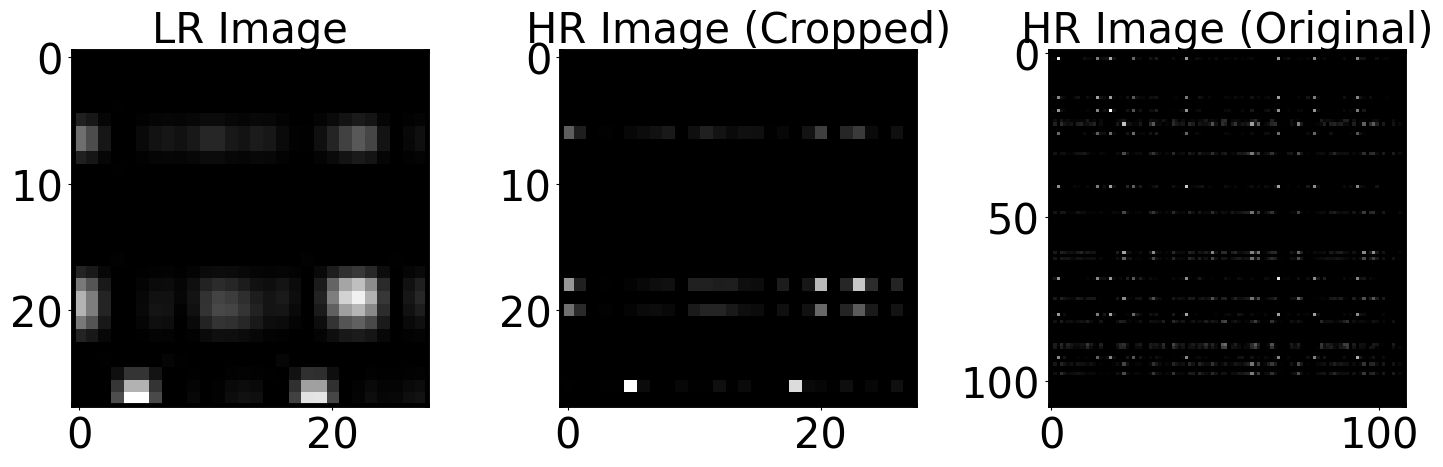

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Test the function
crop_size = 32  # Replace with your crop size
scale_factor = 2  # Replace with your scale factor

# Select a random sample from hr_original
sample_index = np.random.randint(0, len(hr_original))
image = hr_original[sample_index]

# Sample a random pair of lr_images and hr_images
# Pick a random lr image from lr_images
lr_index = np.random.randint(0, len(lr_images))
lr = lr_images[lr_index]
hr = hr_images[lr_index]

# Show a sample image from hr_original
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(lr, cmap='gray')
axs[0].set_title('LR Image', fontsize=30)
axs[1].imshow(hr, cmap='gray')
axs[1].set_title('HR Image (Cropped)', fontsize=30)
axs[2].imshow(hr_original[sample_index], cmap='gray')
axs[2].set_title('HR Image (Original)', fontsize=30)
plt.tight_layout()
plt.show()


In [11]:
from utils.models import srcnn, vdsr, edsr

#  Function to train any model (SRCNN in this case)
def train_model(model: tf.keras.Model, train_images, train_labels, val_images, val_labels, epochs=10, batch_size=32):
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(train_images, train_labels, epochs=epochs, batch_size=batch_size, validation_data=(val_images, val_labels))
    return model

# Define the model
model_srcnn = srcnn()
model_vdsr = vdsr()
model_edsr = edsr(scale=2)

TRAIN SRCNN

In [12]:
# model_srcnn = train_model(model_srcnn, lr_images, hr_images, lr_images_val, hr_images_val, epochs=10, batch_size=32)

TRAIN VDSR

In [13]:
# model_vdsr = train_model(model_vdsr, lr_images, hr_images, lr_images_val, hr_images_val, epochs=10, batch_size=32)

TRAIN EDSR

In [14]:
from keras import backend as K
def PSNR(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [15]:
import pandas as pd
# Generate low-res and high-res pairs
# Split the data into train, test, and validation sets
train_data, test_data = train_test_split(hr_original, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
lr_images, hr_images = generate_training_data(hr_original, crop_size=32, scale_factor=2, window_size=28, use_edsr=True)
lr_images_val, hr_images_val = generate_training_data(val_data, crop_size=32, scale_factor=2, window_size=28, use_edsr=True)
lr_images_test, hr_images_test = generate_training_data(test_data, crop_size=32, scale_factor=2, window_size=28, use_edsr=True)

RESIDUAL BLOCKS TUNING

In [19]:
import time
folder = '/home/ubuntu/edtmsr/www_sub'
t_time_list = []
lr_images = lr_images[:1000]
hr_images = hr_images[:1000]
for b in [4, 8, 16, 32, 64, 128]:
    strategy = tf.distribute.MirroredStrategy()
    with strategy.scope():
        model = edsr(scale=2, num_res_blocks=b)
        model.compile(optimizer='adam', loss='mean_squared_error', metrics=[PSNR])
        start_time = time.time()
        history = model.fit(lr_images, hr_images, epochs=100, batch_size=32, validation_data=(lr_images_val, hr_images_val))
        end_time = time.time()
        t_time_list.append(end_time - start_time)
        print(f"Training time for {b} blocks: {end_time - start_time} seconds")
        history = pd.DataFrame(model.history.history)
        history.to_csv(os.path.join(folder, f"edsr_{b}_blocks.csv"))
# Convert the list to a numpy array
t_time = np.array(t_time_list)
# Save the numpy array to a file
np.save(os.path.join(folder, "training_times.npy"), t_time)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2023-10-10 21:11:21.348306: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1000,28,28,1]
	 [[{{node Placeholder/_11}}]]
2023-10-10 21:11:21.348618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1000,28,28,1]
	 [[{{node Placeholder/_11}}]]


Epoch 1/100
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 24 all-reduces with algorithm = nccl, num_packs = 1
32/32 [==============================] - ETA: 0s - loss: 0.0036 - PSNR: 24.6653

2023-10-10 21:11:31.965345: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [20175,28,28,1]
	 [[{{node Placeholder/_11}}]]
2023-10-10 21:11:31.965642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [20175,28,28,1]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 15s 177ms/step - loss: 0.0036 - PSNR: 24.6653 - val_loss: 0.0028 - val_PSNR: 25.6346
Epoch 2/100
32/32 [==============================] - 4s 129ms/step - loss: 0.0023 - PSNR: 26.3931 - val_loss: 0.0030 - val_PSNR: 25.2661
Epoch 3/100
32/32 [==============================] - 4s 124ms/step - loss: 0.0013 - PSNR: 29.1247 - val_loss: 0.0034 - val_PSNR: 24.8030
Epoch 4/100
32/32 [==============================] - 4s 139ms/step - loss: 5.4763e-04 - PSNR: 32.9210 - val_loss: 0.0036 - val_PSNR: 24.4587
Epoch 5/100
32/32 [==============================] - 5s 145ms/step - loss: 2.4270e-04 - PSNR: 36.3277 - val_loss: 0.0036 - val_PSNR: 24.5456
Epoch 6/100
32/32 [==============================] - 4s 144ms/step - loss: 1.4839e-04 - PSNR: 38.3923 - val_loss: 0.0035 - val_PSNR: 24.5832
Epoch 7/100
32/32 [==============================] - 4s 145ms/step - loss: 1.1646e-04 - PSNR: 39.4258 - val_loss: 0.0035 - val_PSNR: 24.6178
Epoch 8/100
32/32 [=================

2023-10-10 21:18:55.770702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1000,28,28,1]
	 [[{{node Placeholder/_11}}]]
2023-10-10 21:18:55.771005: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1000,14,14,1]
	 [[{{node Placeholder/_10}}]]


Epoch 1/100
INFO:tensorflow:batch_all_reduce: 40 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 40 all-reduces with algorithm = nccl, num_packs = 1
30/32 [===========================>..] - ETA: 0s - loss: 0.0057 - PSNR: 23.5193

2023-10-10 21:19:12.950688: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [20175,28,28,1]
	 [[{{node Placeholder/_11}}]]
2023-10-10 21:19:12.950981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [20175,28,28,1]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 23s 202ms/step - loss: 0.0056 - PSNR: 23.5774 - val_loss: 0.0028 - val_PSNR: 25.5589
Epoch 2/100
32/32 [==============================] - 5s 163ms/step - loss: 0.0029 - PSNR: 25.4230 - val_loss: 0.0028 - val_PSNR: 25.5395
Epoch 3/100
32/32 [==============================] - 5s 161ms/step - loss: 0.0023 - PSNR: 26.4258 - val_loss: 0.0031 - val_PSNR: 25.1094
Epoch 4/100
32/32 [==============================] - 5s 161ms/step - loss: 0.0015 - PSNR: 28.2802 - val_loss: 0.0035 - val_PSNR: 24.6439
Epoch 5/100
32/32 [==============================] - 4s 132ms/step - loss: 8.5623e-04 - PSNR: 30.8448 - val_loss: 0.0037 - val_PSNR: 24.3735
Epoch 6/100
32/32 [==============================] - 4s 140ms/step - loss: 4.6092e-04 - PSNR: 33.5485 - val_loss: 0.0038 - val_PSNR: 24.2997
Epoch 7/100
32/32 [==============================] - 5s 162ms/step - loss: 2.5465e-04 - PSNR: 36.0704 - val_loss: 0.0038 - val_PSNR: 24.2645
Epoch 8/100
32/32 [=====================

2023-10-10 21:27:26.821383: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1000,28,28,1]
	 [[{{node Placeholder/_11}}]]
2023-10-10 21:27:26.821699: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1000,14,14,1]
	 [[{{node Placeholder/_10}}]]


Epoch 1/100
INFO:tensorflow:batch_all_reduce: 72 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 72 all-reduces with algorithm = nccl, num_packs = 1
31/32 [============================>.] - ETA: 0s - loss: 0.0923 - PSNR: 17.1546

2023-10-10 21:27:55.435436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [20175,28,28,1]
	 [[{{node Placeholder/_11}}]]
2023-10-10 21:27:55.435764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [20175,28,28,1]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 35s 257ms/step - loss: 0.0916 - PSNR: 17.1988 - val_loss: 0.0042 - val_PSNR: 23.8210
Epoch 2/100
32/32 [==============================] - 6s 199ms/step - loss: 0.0042 - PSNR: 23.8129 - val_loss: 0.0033 - val_PSNR: 24.8232
Epoch 3/100
32/32 [==============================] - 6s 200ms/step - loss: 0.0035 - PSNR: 24.5761 - val_loss: 0.0031 - val_PSNR: 25.0808
Epoch 4/100
32/32 [==============================] - 6s 200ms/step - loss: 0.0032 - PSNR: 24.9934 - val_loss: 0.0031 - val_PSNR: 25.2105
Epoch 5/100
32/32 [==============================] - 6s 200ms/step - loss: 0.0030 - PSNR: 25.2898 - val_loss: 0.0030 - val_PSNR: 25.2307
Epoch 6/100
32/32 [==============================] - 6s 201ms/step - loss: 0.0028 - PSNR: 25.5498 - val_loss: 0.0030 - val_PSNR: 25.2383
Epoch 7/100
32/32 [==============================] - 6s 201ms/step - loss: 0.0026 - PSNR: 25.8158 - val_loss: 0.0031 - val_PSNR: 25.2046
Epoch 8/100
32/32 [==============================] -

2023-10-10 21:38:25.871642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1000,28,28,1]
	 [[{{node Placeholder/_11}}]]
2023-10-10 21:38:25.871934: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1000,28,28,1]
	 [[{{node Placeholder/_11}}]]


Epoch 1/100
31/32 [============================>.] - ETA: 0s - loss: 665.8889 - PSNR: -11.6312

2023-10-10 21:39:19.532775: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [20175,28,28,1]
	 [[{{node Placeholder/_11}}]]
2023-10-10 21:39:19.533063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [20175,28,28,1]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 63s 363ms/step - loss: 660.5674 - PSNR: -11.5258 - val_loss: 1.2899 - val_PSNR: -1.1005
Epoch 2/100
32/32 [==============================] - 9s 281ms/step - loss: 0.3609 - PSNR: 5.5216 - val_loss: 0.1069 - val_PSNR: 9.7338
Epoch 3/100
32/32 [==============================] - 7s 221ms/step - loss: 0.0895 - PSNR: 10.5579 - val_loss: 0.0706 - val_PSNR: 11.5375
Epoch 4/100
32/32 [==============================] - 8s 271ms/step - loss: 0.0627 - PSNR: 12.0724 - val_loss: 0.0575 - val_PSNR: 12.4233
Epoch 5/100
32/32 [==============================] - 9s 276ms/step - loss: 0.0501 - PSNR: 13.0439 - val_loss: 0.0470 - val_PSNR: 13.2976
Epoch 6/100
32/32 [==============================] - 9s 277ms/step - loss: 0.0404 - PSNR: 13.9704 - val_loss: 0.0399 - val_PSNR: 14.0133
Epoch 7/100
32/32 [==============================] - 9s 279ms/step - loss: 0.0332 - PSNR: 14.8298 - val_loss: 0.0335 - val_PSNR: 14.7753
Epoch 8/100
32/32 [==============================] 

2023-10-10 21:53:27.454677: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1000,28,28,1]
	 [[{{node Placeholder/_11}}]]
2023-10-10 21:53:27.455080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1000,14,14,1]
	 [[{{node Placeholder/_10}}]]


Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: 2205646592.0000 - PSNR: -75.5392

2023-10-10 21:55:14.547957: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [20175,28,28,1]
	 [[{{node Placeholder/_11}}]]
2023-10-10 21:55:14.548243: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [20175,28,28,1]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 122s 557ms/step - loss: 2205646592.0000 - PSNR: -75.5392 - val_loss: 1344346.0000 - val_PSNR: -61.2766
Epoch 2/100
32/32 [==============================] - 10s 334ms/step - loss: 304645.1875 - PSNR: -52.5242 - val_loss: 36590.8789 - val_PSNR: -45.6280
Epoch 3/100
32/32 [==============================] - 13s 402ms/step - loss: 24881.9102 - PSNR: -43.7727 - val_loss: 14055.5674 - val_PSNR: -41.4713
Epoch 4/100
32/32 [==============================] - 12s 401ms/step - loss: 12440.8477 - PSNR: -40.9027 - val_loss: 8997.7480 - val_PSNR: -39.5336
Epoch 5/100
32/32 [==============================] - 13s 419ms/step - loss: 8570.5039 - PSNR: -39.3012 - val_loss: 6572.6611 - val_PSNR: -38.1693
Epoch 6/100
32/32 [==============================] - 13s 401ms/step - loss: 6514.9448 - PSNR: -38.1163 - val_loss: 5141.6250 - val_PSNR: -37.1025
Epoch 7/100
32/32 [==============================] - 12s 401ms/step - loss: 5234.7290 - PSNR: -37.1687 - val_loss: 4194.

2023-10-10 22:15:42.427202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1000,28,28,1]
	 [[{{node Placeholder/_11}}]]
2023-10-10 22:15:42.427566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1000,28,28,1]
	 [[{{node Placeholder/_11}}]]


Epoch 1/100
32/32 [==============================] - ETA: 0s - loss: nan - PSNR: nan

2023-10-10 22:19:29.159369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [20175,28,28,1]
	 [[{{node Placeholder/_11}}]]
2023-10-10 22:19:29.159662: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [20175,28,28,1]
	 [[{{node Placeholder/_11}}]]


32/32 [==============================] - 253s 985ms/step - loss: nan - PSNR: nan - val_loss: nan - val_PSNR: nan
Epoch 2/100
32/32 [==============================] - 20s 655ms/step - loss: nan - PSNR: nan - val_loss: nan - val_PSNR: nan
Epoch 3/100
32/32 [==============================] - 21s 675ms/step - loss: nan - PSNR: nan - val_loss: nan - val_PSNR: nan
Epoch 4/100
32/32 [==============================] - 21s 686ms/step - loss: nan - PSNR: nan - val_loss: nan - val_PSNR: nan
Epoch 5/100
32/32 [==============================] - 21s 684ms/step - loss: nan - PSNR: nan - val_loss: nan - val_PSNR: nan
Epoch 6/100
32/32 [==============================] - 20s 647ms/step - loss: nan - PSNR: nan - val_loss: nan - val_PSNR: nan
Epoch 7/100
32/32 [==============================] - 21s 659ms/step - loss: nan - PSNR: nan - val_loss: nan - val_PSNR: nan
Epoch 8/100
32/32 [==============================] - 21s 684ms/step - loss: nan - PSNR: nan - val_loss: nan - val_PSNR: nan
Epoch 9/100
32/32 [